In [2]:
import pandas as pd

# Read data
df = pd.read_excel("MyFoodData.xlsx")

# Drops unrelevant columns
df = df.filter(items = ["Name", "Calories", "Protein (g)"])
df.head()

,Name,Calories,Protein (g)
0,Pillsbury Golden Layer Buttermilk Biscuits Art...,307.0,5.88
1,Pillsbury Cinnamon Rolls With Icing Refrigerat...,330.0,4.34
2,Kraft Foods Shake N Bake Original Recipe Coati...,377.0,6.10
3,George Weston Bakeries Thomas English Muffins,232.0,8.00
4,Waffles Buttermilk Frozen Ready-To-Heat,273.0,6.58


In [146]:
def calculateFitness(chromosome: list, maxWeight: int, negative: bool):
    totalValue = 0
    totalWeight = 0

    for i in range(len(chromosome)):
        if chromosome[i]:
            value = df.iloc[i]['Protein (g)']
            totalValue += value
            
            weight = df.iloc[i]['Calories']
            totalWeight += weight
    
    penalty = 0.1
    proteinWeight = 5
    # Fitness = Total Proteins - (Total Calories - Max Calorie Given as Input) * Penalty Value
    fitness = proteinWeight * totalValue - (totalWeight - maxWeight) * penalty

    if not negative:
        return max(0, fitness)
    else:
        return fitness

In [4]:
import random 

def initializePopulation(populationSize: int, chromosomeSize: int):
    population = []

    # Randomly generate populationSize amount of chromosomes with chromosomeSize size
    for i in range(populationSize):
        member = [random.randint(0, 1) for i in range(chromosomeSize)]
        population.append(member)
       
    return population

In [157]:
def sortPopulation(population: list[list], maxWeight: int, negative: bool):
    return sorted(population, key=lambda individual: calculateFitness(individual, maxWeight, negative), reverse=True)

population = initializePopulation(5, 5)
for i in population:
    print(f"{i}, Fitness {calculateFitness(i, 2000, False)}")
print()
population = sortPopulation(population, 2000, False)
for i in population:
    print(f"{i}, Fitness {calculateFitness(i, 2000, False)}")

[0, 0, 0, 1, 0], Fitness 216.8
[1, 0, 1, 1, 1], Fitness 213.90000000000003
[0, 0, 0, 0, 0], Fitness 200.0
[1, 0, 0, 0, 1], Fitness 204.3
[1, 0, 1, 0, 1], Fitness 197.10000000000002

[0, 0, 0, 1, 0], Fitness 216.8
[1, 0, 1, 1, 1], Fitness 213.90000000000003
[1, 0, 0, 0, 1], Fitness 204.3
[0, 0, 0, 0, 0], Fitness 200.0
[1, 0, 1, 0, 1], Fitness 197.10000000000002


In [5]:
def rouletteWheelSelection(population: list[list], maxWeight: int):
    total_fitness = 0
    fitnesses = []

    # Add all fitnesses
    for i in population:
        # Negative fitness is not allowed
        fitness = calculateFitness(i, maxWeight, False)
        fitnesses.append(fitness)
        total_fitness += fitness

    # An individual in the population have fitness / (sum of all fitnesses) chance to be selected in the Roulette Wheel Selection
    prob_sum = 0
    # Random float as roulette
    roulette = random.uniform(0, total_fitness)
    for i in range(len(population)):
        # If the prob_sum + fitness of the individual exceedes the roulette value, the roulette is in that probability area, so the individual is selected
        # Example:
        # If we have 5 individuals with fitness values 5, 10, 15, 6, 3 and roulette as 21, the individual with fitness value 15 should be selected.
        # In the first iteration of the loop prob_sum would be 5, in the second iteration 15 and in the third iteration it would be 30, exceeding the roulette value
        # Third individual from the population would be selected according to this algorithm
        prob_sum += fitnesses[i]
        if prob_sum > roulette:
            return population[i]

        

In [127]:
def tournamentSelection(population: list[list], tournamentSize: int, maxWeight: int):
    # tournamentSize amount of individuals are selected for the tournament
    randomIndividuals = random.sample(range(0, len(population)), tournamentSize)
    bestFitness = -1
    bestIndividual = []
    #print(randomIndividuals)
    
    for i in randomIndividuals:
        # Individual with best fitness wins the tournament
        # This individual is selected
        fitness = calculateFitness(population[i], maxWeight, False)
        #print(f"Individual {i}, fitness {fitness}")
        if fitness > bestFitness:
            bestFitness = fitness
            bestIndividual = i
    return population[bestIndividual]


In [119]:
population = initializePopulation(10, 5)

bestIndividual = tournamentSelection(population, 4, 2500)
print(bestIndividual)

[1, 0, 5, 7]
Individual 1, fitness 107.80999999999999
Individual 0, fitness 73.57
Individual 5, fitness 81.08
Individual 7, fitness 78.06
[0, 1, 1, 1, 0]


In [6]:
population = initializePopulation(10, 5)
for i in range(len((population))):
    print(population[i], calculateFitness(population[i], 2500, False))

print()
selected = rouletteWheelSelection(population, 2500)
print(selected)

[1, 0, 1, 1, 1] 682.06
[0, 1, 0, 1, 0] 981.34
[0, 0, 0, 1, 0] 1142.0
[1, 1, 1, 1, 1] 521.4
[0, 1, 1, 1, 1] 669.02
[0, 1, 1, 0, 1] 777.02
[0, 0, 1, 0, 0] 1067.6
[1, 1, 1, 1, 1] 521.4
[0, 1, 1, 0, 1] 777.02
[1, 1, 1, 0, 0] 759.32

[0, 0, 0, 1, 0]


In [7]:
import random

def singlePointCrossover(firstParent: list, secondParent: list):

   # Selects a random crossover point
   crossOverPoint = random.randint(1, len(firstParent) - 1)

   # Selects the crossover parts from parents (From random point to end of the chromosome)
   crossOverPart1 = firstParent[crossOverPoint: len(firstParent)]
   crossOverPart2 = secondParent[crossOverPoint: len(secondParent)]

   firstOffspring = firstParent
   secondOffspring = secondParent

   # Swaps the crossover parts between parents
   firstOffspring[crossOverPoint: len(firstParent)] = crossOverPart2
   secondOffspring[crossOverPoint: len(secondParent)] = crossOverPart1

   return [firstOffspring, secondOffspring]

In [8]:
firstParent = [0, 0 , 1, 1, 0, 1]
secondParent = [1, 1, 0, 0, 0, 1]

offsprings = singlePointCrossover(firstParent, secondParent)
print(offsprings)

[[0, 0, 1, 1, 0, 1], [1, 1, 0, 0, 0, 1]]


In [9]:
def multiplePointCrossover(firstParent: list, secondParent: list):
    # Selects two random crossover points
    firstCrossOverPoint = random.randint(1, len(firstParent) - 1)
    secondCrossOverPoint = random.randint(1, len(secondParent) - 1)

    # Change the crossover point if the points are same
    while (firstCrossOverPoint == secondCrossOverPoint):
        secondCrossOverPoint = random.randint(1, len(firstParent) - 1)
    
    # If the first crossover point is at the right of the second crossover point swap the points
    if (firstCrossOverPoint > secondCrossOverPoint):
        firstCrossOverPoint, secondCrossOverPoint = secondCrossOverPoint, firstCrossOverPoint
    
    # Select the crossover parts from point1 to point2
    crossOverPart1 = firstParent[firstCrossOverPoint: secondCrossOverPoint + 1]
    crossOverPart2 = secondParent[firstCrossOverPoint: secondCrossOverPoint + 1]

    firstOffspring = firstParent
    secondOffspring = secondParent

    # Swap the crossover parts between parents
    firstOffspring[firstCrossOverPoint: secondCrossOverPoint + 1] = crossOverPart2
    secondOffspring[firstCrossOverPoint: secondCrossOverPoint + 1] = crossOverPart1

    return [firstOffspring, secondOffspring]

    


In [10]:
firstParent = [0, 0 , 1, 1, 0, 1]
secondParent = [1, 1, 0, 0, 0, 1]

offsprings = multiplePointCrossover(firstParent, secondParent)
print(offsprings)

[[0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 0, 1]]


In [11]:
def uniformCrossover(firstParent: list, secondParent: list, maxWeight: int):
    firstFitness = calculateFitness(firstParent, maxWeight, False)
    secondFitness = calculateFitness(secondParent, maxWeight, False)

    # Probability in the uniform crossover is fp_1 / (fp_1 + fp_2), where fp_1 is the fitness of the first parent and fp_2 is the fitness of the second parent
    probability = firstFitness / (firstFitness + secondFitness)

    firstOffspring = []
    secondOffspring = []
    i = 0

    while (len(firstOffspring) != len(firstParent)):
        randomProb = random.random()
        # First chromosome have the chance fp_1 / (fp_1 + fp_2) to the get the gene from first parent.
        # If the probability is higher than the random value, first offspring gets the gene from first parent
        # This repeats for all of the genes (length of the chromosome)
        if (randomProb < probability):
            firstOffspring.append(firstParent[i])
            secondOffspring.append(secondParent[i])
        else:
            firstOffspring.append(secondParent[i])
            secondOffspring.append(firstParent[i])
        i += 1

    return [firstOffspring, secondOffspring]



In [12]:
firstParent = [0, 0 , 1, 1, 0, 1]
secondParent = [1, 1, 0, 0, 0, 1]

offsprings = uniformCrossover(firstParent, secondParent, 1000)
print(offsprings)

[[1, 1, 1, 1, 0, 1], [0, 0, 0, 0, 0, 1]]


In [ ]:
def mutation(chromosome: list, rate: int):
    mutationsRate = 1 / rate
    for i in range(len(chromosome)):
        # random.random() generates a float between 0 and 1
        # If this number is less than or equal to mutation rate there is a bit flip in that gene (mutation occurs)
        if random.random() <= mutationsRate:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

In [14]:
chromosome = [0, 0, 1, 1, 1, 0, 1]
print(mutation(chromosome, 10))

[0, 1, 1, 1, 1, 0, 0]


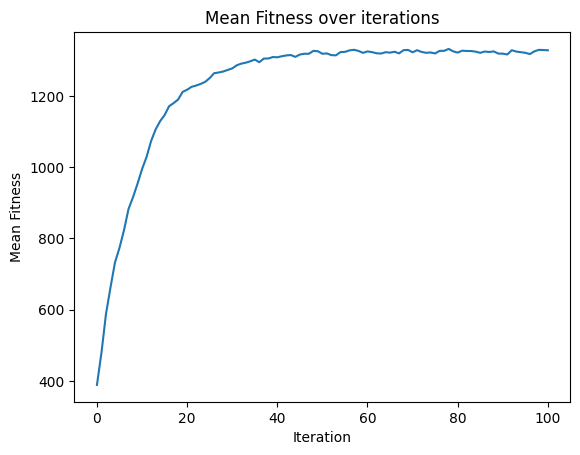

In [171]:
import numpy as np
import matplotlib.pyplot as plt

population = initializePopulation(100, 100)

def geneticAlgorithm(population: list[list], maxWeight: int, iterations: int, elitSize: int):
    meanFitness = []
    fitnessList = [calculateFitness(i, maxWeight, True) for i in population]
    mean = np.mean(fitnessList)
    meanFitness.append(mean)

    for i in range(iterations):
        sortedPopulation = sortPopulation(population, maxWeight, True)
        new_population = sortedPopulation[:elitSize]
        while len(new_population) != len(population):
            
            firstIndividual = tournamentSelection(population, 2, maxWeight)
            secondIndividual = tournamentSelection(population, 2, maxWeight)

            #firstIndividual = rouletteWheelSelection(population, maxWeight)
            #secondIndividual = rouletteWheelSelection(population, maxWeight)
            
            #offsprings = singlePointCrossover(firstIndividual, secondIndividual)
            offsprings = uniformCrossover(firstIndividual, secondIndividual, maxWeight)
            offsprings[0] = mutation(offsprings[0], len(offsprings[0]))
            offsprings[1] = mutation(offsprings[1], len(offsprings[1]))

            new_population.extend(offsprings)

        population = new_population

        fitnessList = [calculateFitness(i, maxWeight, True) for i in population]
        mean = np.mean(fitnessList)
        meanFitness.append(mean)

    x = np.arange(0, iterations + 1)
    plt.plot(x, meanFitness)
    plt.title("Mean Fitness over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Fitness")
    return population

new = geneticAlgorithm(population, 5000, 100, 2)
